# ASSESSING NEAR EARTH COMETS HAZARDOUS POTENTIAL USING MACHINE LEARNING

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Loading in the data

In [73]:
# Load the dataset
df = pd.read_csv('Near-Earth_Comets_-_Orbital_Elements_20241021.csv')

print(df.columns)

Index(['Object', 'Epoch (TDB)', 'TP (TDB)', 'e', 'i (deg)', 'w (deg)',
       'Node (deg)', 'q (AU)', 'Q (AU)', 'P (yr)', 'MOID (AU)', 'A1 (AU/d^2)',
       'A2 (AU/d^2)', 'A3 (AU/d^2)', 'DT (d)', 'ref', 'Object_name'],
      dtype='object')


## Data Preprocessing

In [76]:
df.drop(columns=['A1 (AU/d^2)', 'A2 (AU/d^2)', 'A3 (AU/d^2)', 'DT (d)', 'ref'], inplace=True)
df.drop(columns=['Object', 'Object_name', 'MOID (AU)'], inplace=True)
# Reload MOID for labeling
df['MOID'] = pd.read_csv('Near-Earth_Comets_-_Orbital_Elements_20241021.csv')['MOID (AU)']

## Hazardous comets are known comets with a MOID value less than 0.05

In [79]:
df['Hazardous'] = df['MOID'] < 0.05 

In [81]:
# Converting to integer labels (1 for hazardous, 0 for non-hazardous)
df['Hazardous'] = df['Hazardous'].astype(int)

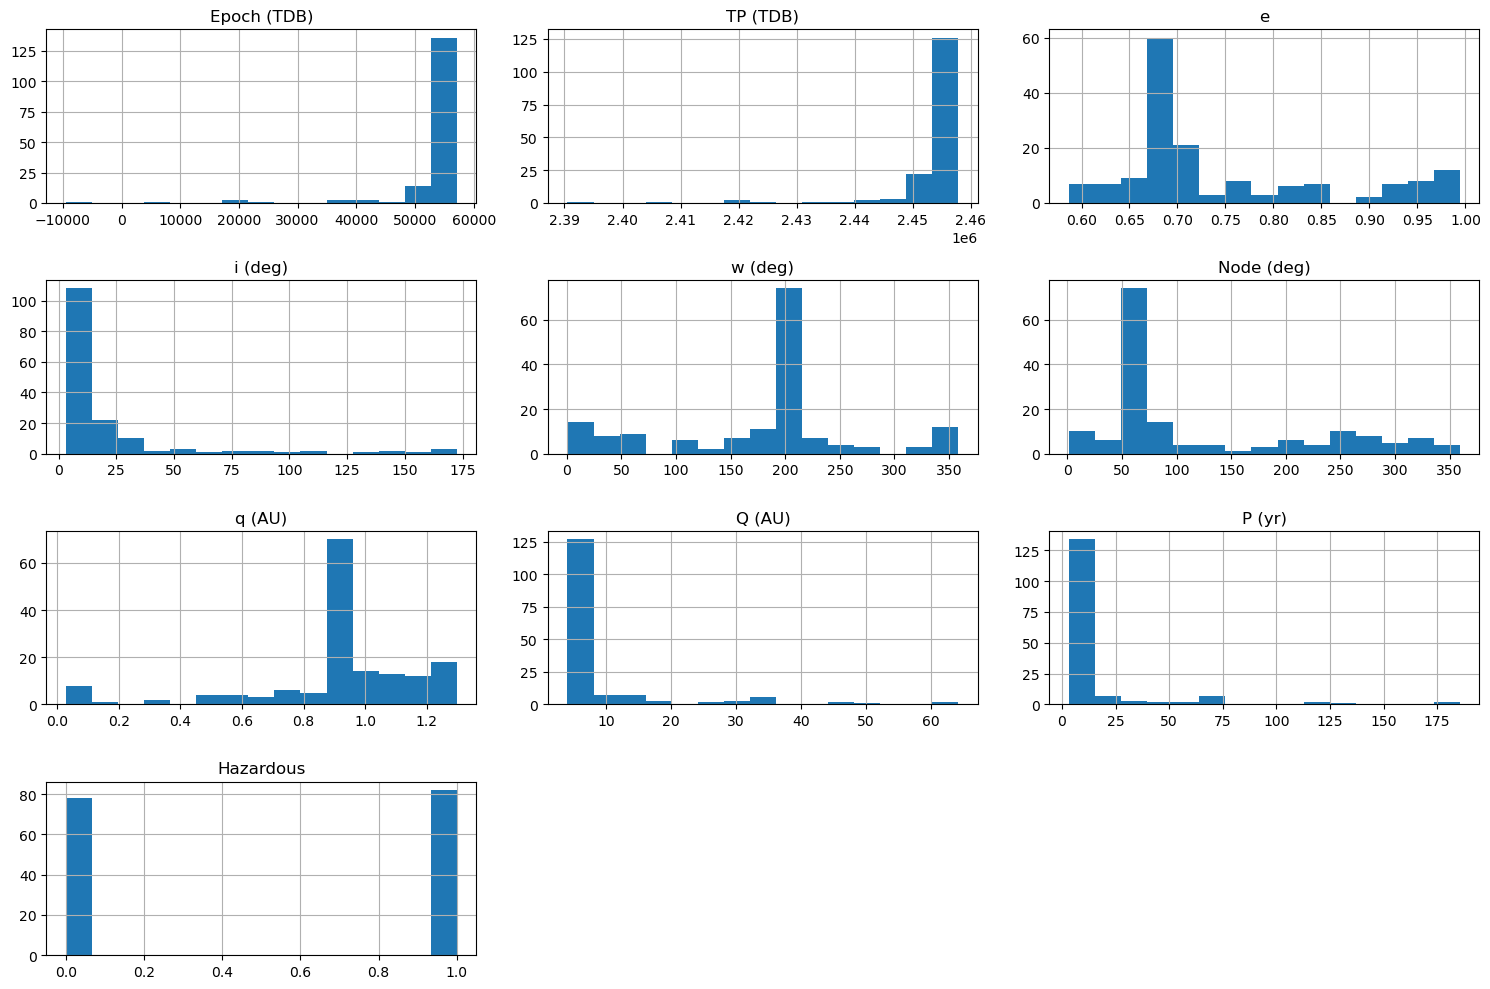

In [83]:
# Droping the MOID column
df.drop(columns=['MOID'], inplace=True)
# Plot histograms of features
df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

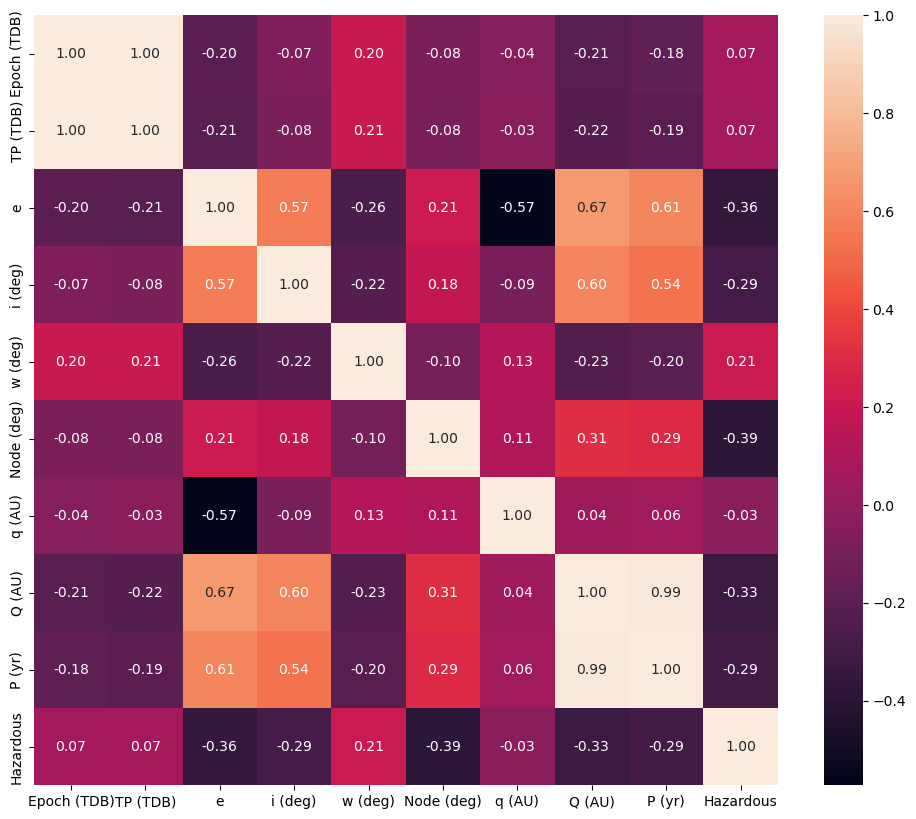

In [85]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [87]:
#Separating the features from the targets
X = df.drop('Hazardous', axis=1)
y = df['Hazardous']

## Model Selection and Training

In [90]:
#Standarizing features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[num_features])

X = pd.DataFrame(X_scaled, columns=num_features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [92]:
#Selected models and seeing which performs better
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Logistic Regression AUC: 0.7884 ± 0.0972
Random Forest AUC: 0.9091 ± 0.0345
SVM AUC: 0.8999 ± 0.0489


In [94]:
# Training on the full training set
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


In [96]:
#Testing best parameters for Random Forest
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)


Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [97]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.81      0.90        16

    accuracy                           0.91        32
   macro avg       0.92      0.91      0.91        32
weighted avg       0.92      0.91      0.91        32



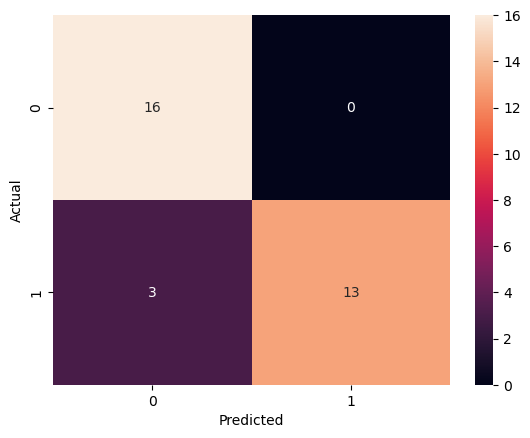

In [100]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

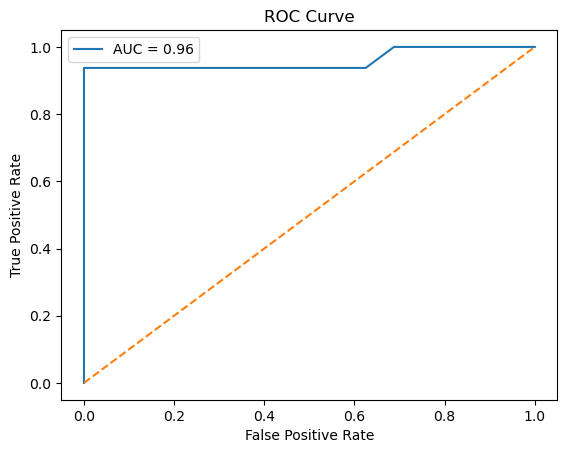

In [102]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()